## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import accuracy_score

%matplotlib inline

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.05MB/s]


Text(0.5, 1.0, 'Image label: 6')

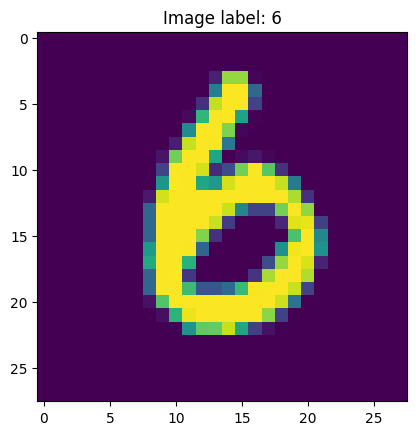

In [2]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [15]:
class Perceptron(nn.Module):
  def __init__(self, input_size, output_size, hidden_size=1024):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Softmax(1)

  def forward(self, data):
    data = self.relu(self.fc1(data))
    data = self.relu(self.fc2(data))
    data = self.fc3(data)
    return self.softmax(data)

In [16]:
# Creating model instance
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Perceptron(784, 10)
model.to(device)

Perceptron(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Ниже доступны локальные тесты для проверки вашей модели:

In [17]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x.to(device))
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [18]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-4)

In [19]:
def plot_train_process(
    train_loss, test_loss, train_accuracy, test_accuracy, title_suffix=''):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))
  axes[0].set_title(" ".join(["Loss", title_suffix]))
  axes[0].plot(train_loss, label="train")
  axes[0].plot(test_loss, label="test")
  axes[0].legend()

  axes[1].set_title(" ".join(["Test accuracy", title_suffix]))
  axes[1].plot(train_accuracy, label="train")
  axes[1].plot(test_accuracy, label="test")
  axes[1].legend()
  plt.show()

In [20]:
def train_model(model, loss_fn, optim, train_loader, test_loader,
               num_epochs=500, eval_every=10, show_plot=True):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []

    for epoch in range(num_epochs):

        X_batch, y_batch = next(iter(train_loader))

        outs = model(X_batch.reshape(-1, 784).to(device))

        preds = torch.argmax(outs, dim=1)
        loss = loss_fn(outs, y_batch.to(device))

        loss.backward()

        optim.step()

        optim.zero_grad()

        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                preds.to('cpu').detach().numpy()
            )
        )
        local_train_loss_history.append(loss.item())

        if (epoch % eval_every == 0):
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            model.eval()
            with torch.no_grad():

                X_val, y_val = next(iter(test_loader))

                outputs_val = model(X_val.reshape(-1, 784).to(device))

                preds_val = torch.argmax(outputs_val, dim=1)
                val_loss_history.append(loss_fn(outputs_val, y_val.to(device)).item())

                val_acc_score = accuracy_score(
                    y_val.to('cpu').detach().numpy(),
                    preds_val.to('cpu').detach().numpy()
                )
                val_acc_history.append(val_acc_score)

            if show_plot:
                clear_output(wait=True)
                plot_train_process(
                    train_loss_history, val_loss_history, train_acc_history, val_acc_history
                )

    return model

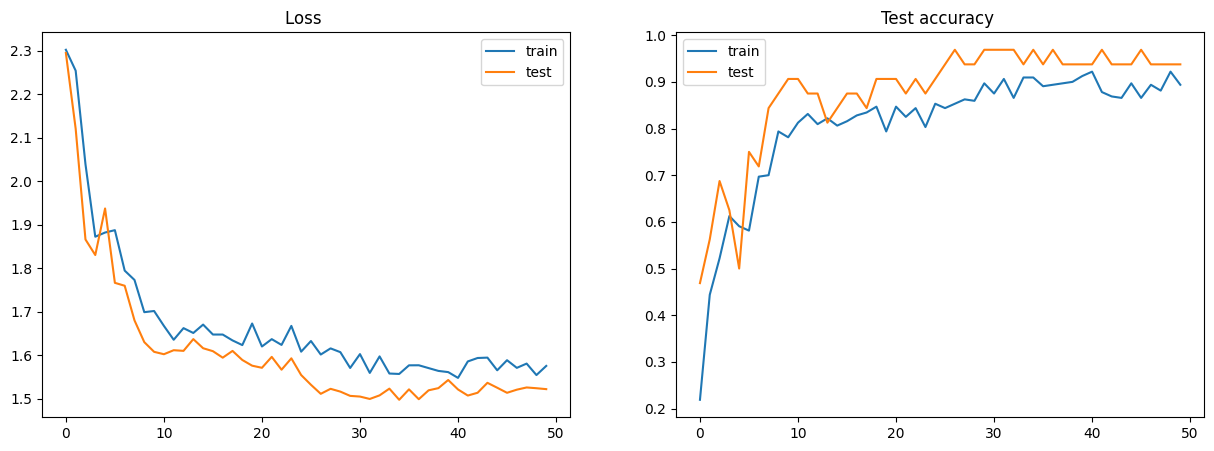

In [21]:
model = train_model(model, loss_fn, opt, train_data_loader, test_data_loader)

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [22]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784).to(device))
        predicted_labels.append(y_predicted.to('cpu').argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [23]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.91967


In [24]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].to(device).reshape(-1, 784))
        predicted_labels.append(y_predicted.to('cpu').argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [25]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9208


Проверка, что пороги пройдены:

In [26]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [29]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].to(device).reshape(-1, 784))
            predicted_labels.append(y_predicted.to('cpu').argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!